# Quora Question Pairs
https://www.kaggle.com/c/quora-question-pairs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [2]:
df = pd.read_csv('../Data/train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We don't have a lot of columns in this dataset.  
**id**: this is the id of the pair.  
**qid1** and **qid2**: those are the ids of question 1 and question 2. They seem to be ids given for this particular dataset and are not related to quora's question id.  
**question1** and **question2**: this is the text of the questions.  
**is_duplicate**: this is the label we'll have to predict. 1 if the pair is a duplicate. 0 otherwise.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
def feature_chart(dataframe, count, group):
    df = dataframe.groupby([count, group])[group].count().unstack(count)
    df.fillna(0, inplace=True)
    df['percent_duplicate'] = (df[1] / (df[0] + df[1])) * 100
    print(df)
    #df[[0,1]].plot(kind='bar', stacked=True) 
    df['percent_duplicate'].plot(kind='bar')

In [6]:
# class balance
df.groupby('is_duplicate').size()

is_duplicate
0    255027
1    149263
dtype: int64

We're having an imbalanced dataset that will require resampling.  
## Characters count
I want to count the difference in the number of characters between question1 and question2.  
Then I will look for a correlation between this value and the label.

In [7]:
# comparing the questions length and check for correlation with labels
df['char_count1'] = df['question1'].apply(lambda x: len(x))
df['char_count2'] = df['question2'].apply(lambda x: len(str(x)))
df['char_diff'] = abs(df['char_count1'] - df['char_count2'])
df['char_diff'].describe()
#df['char_diff'].plot(kind='bar')

count    404290.000000
mean         20.158179
std          25.584401
min           0.000000
25%           4.000000
50%          12.000000
75%          26.000000
max        1080.000000
Name: char_diff, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x7f357d7ca278>],
 'caps': [<matplotlib.lines.Line2D at 0x7f357d7dfc50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f357d7e8e80>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f357d7e8668>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f35bdd3e358>,
  <matplotlib.lines.Line2D at 0x7f357d7cae10>]}

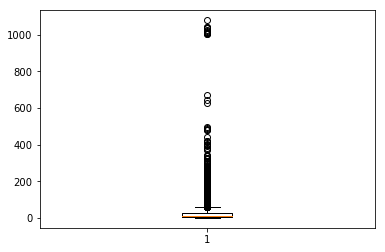

In [8]:
plt.boxplot(df.char_diff)

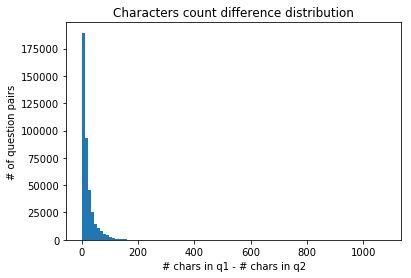

In [9]:
# I want to visualize the part of duplicates per character count difference
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df.char_diff, bins=100)
plt.title('Characters count difference distribution')
plt.xlabel('# chars in q1 - # chars in q2')
plt.ylabel('# of question pairs')
plt.show()

I will keep only the pairs that have a under 200 characters

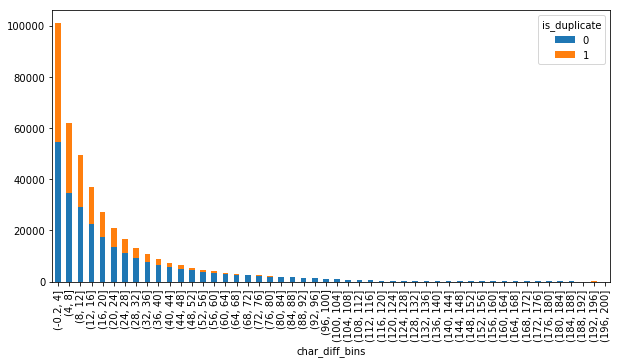

In [10]:
df_char = df[['char_diff','is_duplicate']]
df_char = df_char[(df_char['char_diff'] >= 0) & (df_char['char_diff'] <= 200)]
df_char['char_diff_bins'] = pd.cut(df_char.char_diff,50)
df_char = df_char.groupby(['char_diff_bins','is_duplicate'])['char_diff_bins'].count().unstack('is_duplicate')
#df_char['duplicate_pct'] = (df_char[1] / (df_char[0] + df_char[1])) * 100

fig, ax = plt.subplots(figsize=(10,5))
ax = df_char[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.show()

## Words count
I am going to do the same exercise than before but I will count words instead of characters.

In [11]:
# comparing words count
df['tokens1'] = df['question1'].apply(lambda x: nltk.word_tokenize(x))
df['word_count1'] = df['tokens1'].apply(lambda x: len(x))
df['tokens2'] = df['question2'].apply(lambda x: nltk.word_tokenize(str(x)))
df['word_count2'] = df['tokens2'].apply(lambda x: len(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,char_count1,char_count2,char_diff,tokens1,word_count1,tokens2,word_count2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,"[What, is, the, step, by, step, guide, to, inv...",15,"[What, is, the, step, by, step, guide, to, inv...",13
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,"[What, is, the, story, of, Kohinoor, (, Koh-i-...",11,"[What, would, happen, if, the, Indian, governm...",16
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,"[How, can, I, increase, the, speed, of, my, in...",15,"[How, can, Internet, speed, be, increased, by,...",11
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,"[Why, am, I, mentally, very, lonely, ?, How, c...",13,"[Find, the, remainder, when, [, math, ], 23^, ...",19
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,"[Which, one, dissolve, in, water, quikly, suga...",16,"[Which, fish, would, survive, in, salt, water, ?]",8


In [12]:
df['word_diff'] = abs(df['word_count1'] - df['word_count2'])
df['word_diff'].describe()

count    404290.000000
mean          4.098677
std           5.519715
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         257.000000
Name: word_diff, dtype: float64

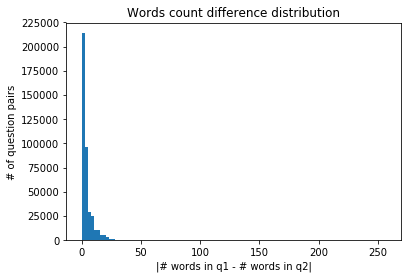

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df.word_diff, bins=100)
plt.title('Words count difference distribution')
plt.xlabel('|# words in q1 - # words in q2|')
plt.ylabel('# of question pairs')
plt.show()

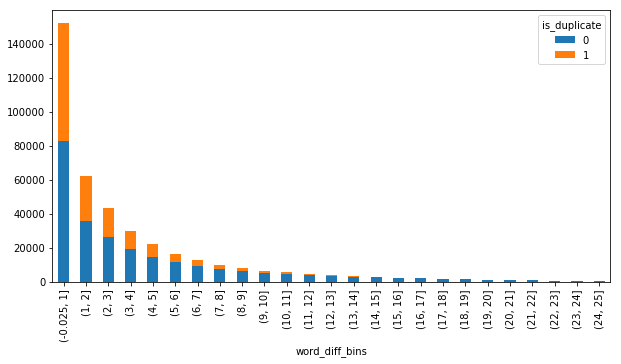

In [14]:
df_word = df[['word_diff','is_duplicate']]
# because the distribution is skewed, I keep only the values below 25,
# which represent most of the cases
df_word = df_word[(df_word['word_diff'] >= 0) & (df_word['word_diff'] <= 25)]

df_word['word_diff_bins'] = pd.cut(df_word.word_diff,25)
df_word = df_word.groupby(['word_diff_bins','is_duplicate'])['word_diff_bins'].count().unstack('is_duplicate')

fig, ax = plt.subplots(figsize=(10,5))
ax = df_word[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.show()

## Question words
I want to extract the question word from each question and look at the impact of different words used in the pair.

In [15]:
question_words = ['what','where','when','why','who','which','whose','how']
def get_qword(question):
    ''' extract the question word from a string
    parameters:
    ----------
        question    string
            the sentence the question words needs
            to be extracted from
    return:
    -------
        word    string
            a question word
    '''
    
    question = str(question).lower()
    
    for word in question_words:
        if word in question:
            return word
        
def compare_qwords(row):
    ''' compares qword1 and qword 2 in a given row
        and returns 1 if they are different and
        0 otherwise
    parameters:
    -----------
        row
            a row of a dataframe
    return:
    -------
        integer
            1 if the question words are different, 
            o otherwise
    '''
    
    if row['qword1'] != row['qword2']:
        return 1
    else:
        return 0
        
df['qword1'] = df['question1'].apply(lambda x: get_qword(x))
df['qword2'] = df['question2'].apply(lambda x: get_qword(x))
df['qword_diff'] = df.apply(lambda row: compare_qwords(row), axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,char_count1,char_count2,char_diff,tokens1,word_count1,tokens2,word_count2,word_diff,qword1,qword2,qword_diff
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,"[What, is, the, step, by, step, guide, to, inv...",15,"[What, is, the, step, by, step, guide, to, inv...",13,2,what,what,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,"[What, is, the, story, of, Kohinoor, (, Koh-i-...",11,"[What, would, happen, if, the, Indian, governm...",16,5,what,what,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,"[How, can, I, increase, the, speed, of, my, in...",15,"[How, can, Internet, speed, be, increased, by,...",11,4,how,how,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,"[Why, am, I, mentally, very, lonely, ?, How, c...",13,"[Find, the, remainder, when, [, math, ], 23^, ...",19,6,why,when,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,"[Which, one, dissolve, in, water, quikly, suga...",16,"[Which, fish, would, survive, in, salt, water, ?]",8,8,which,which,0


is_duplicate       0       1
qword_diff                  
0             130696  104356
1             124331   44907


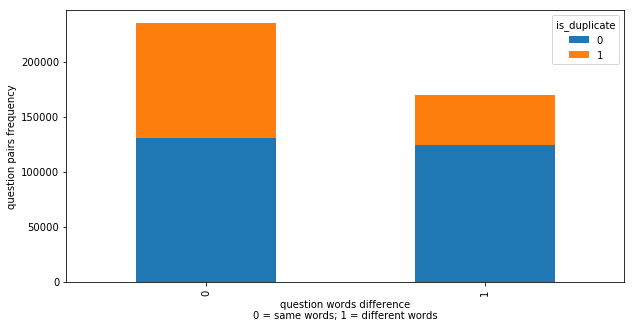

In [16]:
df_qwords = df[['qword_diff','is_duplicate']]
df_qwords = df_qwords.groupby(['qword_diff','is_duplicate'])['qword_diff'].count().unstack('is_duplicate')

print(df_qwords)

fig, ax = plt.subplots(figsize=(10,5))
ax = df_qwords[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.xlabel('question words difference\n0 = same words; 1 = different words')
plt.ylabel('question pairs frequency')
plt.show()

## Comparing questions
I'm now going to compare the questions.  
### Shared words
I'll look at how many words are common to the 2 questions of the pair

In [17]:
from nltk.tokenize import RegexpTokenizer
def share_words_count(q1, q2):
    ''' counts how many words are common to 2 questions
    parameters:
    ----------
        q1,q2    string
            the 2 questions of the pair
    return:
    -------
        integer
            the number of words that appear in both questions
    '''
    
    # convert both strings to all lowercase
    q1 = q1.lower()
    q2 = q2.lower()
    
    # tokenize the sentences without the punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    q1_tokens = tokenizer.tokenize(q1)
    q2_tokens = tokenizer.tokenize(q2)
    
    # remove duplicate words in each list
    set1 = set(q1_tokens)
    set2 = set(q2_tokens)
    
    # return the number of elements that appear in both sets
    # & is intersection of 2 sets
    return len(set1 & set2)  
    

In [18]:
df['shared_words_count'] = df.apply(lambda row: share_words_count(str(row['question1']), str(row['question2'])), axis=1)

is_duplicate              0        1  percent_duplicates
shared_words_count                                      
0                   16358.0      NaN                 NaN
1                   22321.0   1066.0            4.558088
2                   31212.0   7327.0           19.011910
3                   37665.0  16389.0           30.319680
4                   36802.0  24079.0           39.550927
5                   31940.0  27056.0           45.860736
6                   25673.0  24404.0           48.732951
7                   17788.0  18494.0           50.972934
8                   11663.0  11950.0           50.607716
9                    6397.0   6829.0           51.633147
10                   4149.0   3846.0           48.105066
11                   2783.0   2106.0           43.076294
12                   2312.0   1777.0           43.458058
13                   2197.0    782.0           26.250420
14                   1711.0    933.0           35.287443
15                   1247.0    

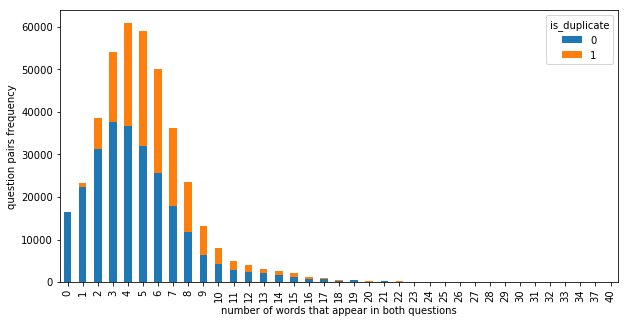

In [19]:
df_shared = df[['shared_words_count','is_duplicate']]
df_shared = df_shared.groupby(['shared_words_count','is_duplicate'])['shared_words_count'].count().unstack('is_duplicate')

df_shared['percent_duplicates'] = (df_shared[1] / (df_shared[0] + df_shared[1])) * 100

print(df_shared)

fig, ax = plt.subplots(figsize=(10,5))
ax = df_shared[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.xlabel('number of words that appear in both questions')
plt.ylabel('question pairs frequency')
plt.show()

In [20]:
df_shared.columns

Index([0, 1, 'percent_duplicates'], dtype='object', name='is_duplicate')

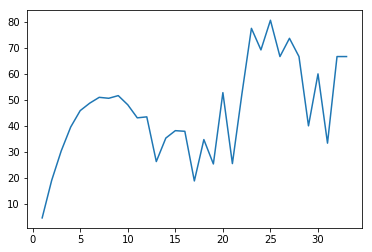

In [21]:
plt.plot(df_shared['percent_duplicates'])

In [22]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'char_count1', 'char_count2', 'char_diff', 'tokens1', 'word_count1',
       'tokens2', 'word_count2', 'word_diff', 'qword1', 'qword2', 'qword_diff',
       'shared_words_count'],
      dtype='object')

In [26]:
def shared_pct(row):
    unique_words = list(set(row['tokens1'] + row['tokens2']))
    unique_words_count = len(unique_words)
    pct_shared = (row['shared_words_count'] / unique_words_count) * 100
    
    return pct_shared
    
df['pct_shared'] = df.apply(lambda row: shared_pct(row), axis=1)

/home/guillaume/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


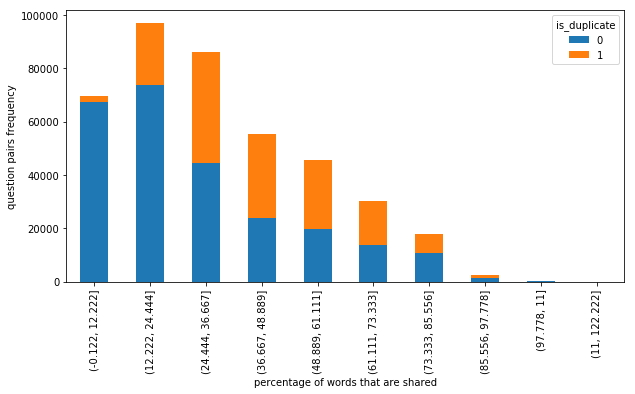

In [30]:
df_pct_shared = df[['pct_shared','is_duplicate']]
df_pct_shared['pct_shared_bins'] = pd.cut(df_pct_shared['pct_shared'],10)

df_pct_shared = df_pct_shared.groupby(['pct_shared_bins','is_duplicate'])['pct_shared_bins'].count().unstack('is_duplicate')


fig, ax = plt.subplots(figsize=(10,5))
ax = df_pct_shared[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.xlabel('percentage of words that are shared')
plt.ylabel('question pairs frequency')
plt.show()